In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches, text, patheffects
plt.rcParams["figure.figsize"]=10,10
from scipy.ndimage import correlate, convolve
from scipy.spatial import distance
from skimage import io
from skimage import color
import numpy as np
import time
import cv2
import random
import os
from pathlib import Path
import copy
import statistics
import time

In [2]:
data_dir = Path(r"C:\Users\lhtMi\Documents\lht\a_fourth_year\CSC420\project\project1 (1)\project1")
clip_1_dir = data_dir / "clip_1"
clip_2_dir = data_dir / "clip_2"
clip_3_dir = data_dir / "clip_3"

# Record all the frame paths
clip_1_img_paths = []
clip_2_img_paths = []
clip_3_img_paths = []
for file in clip_1_dir.iterdir():
    if ".jpg" in file.name:
        clip_1_img_paths.append(file)
for file in clip_2_dir.iterdir():
    if ".jpg" in file.name:
        clip_2_img_paths.append(file)
for file in clip_3_dir.iterdir():
    if ".jpg" in file.name:
        clip_3_img_paths.append(file)

## Shot Detection

By definition, a shot is a continuous footage or sequence between two edits or cuts. To detect shots, we will need to determine whether a frame or frame is a boundary between two shots based on the dissimilarities. We need to use some methods to compute the dissimilarities between every two frames of a video and 

We will use two methods to compute the dissimilarity score:

* Histogram differences: Here, we tried to use two different histogram differences. And later, we found they returned almost the same value and proceeded only to use RGB scale histogram difference.
    * Grayscale histogram: For image 1 and image 2, after transforming both images to grayscale, we calculate their Histogram differences by first computing each image's colour histogram using the "cv2.calcHist" function. Since grayscale pixel values range from 0 to 255, the histogram size is 256 and ranges from 0 to 255, and each histogram bar counts one gray colour. Then we compute the euclidian difference between two images' histograms and use that difference as the score to evaluate the differences between two frames. 
    * RGB scale histogram, we compute one histogram for each colour channel and then compute Euclidean distance for each channel between two images. Then we calculate the average of all channels differences as the score.
* Edge change ratio: Forgiven image 1 and image 2, we first run canny edge detection for each image by setting the hysteresis threshold to be 0 and 200. The lecture shows that the hysteresis threshold is used to accept edges greater than some threshold and connect edges between the threshold. We adjusted the value by experiment so that the edge we detected contains some details of the objects in a scene and facial features but is not detailed enough to capture all the details. Then we dilate the edge by using 'cv2.dilate'. The algorithm is by convolving a filter through the image and setting the filter's centre to be the pixel with a maximum value under the filter. By doing that, we make the edges thicker, and it would be convenient to compute the intersection between two edges which we will do in the next step. To compute the intersection, we count the number of image 1's edges that are within image 2's dilated edge and then divide by image 1's edges. We do that for image 2 as well and take the maximum between those two values.

A shot can be classified into abrupt Transitions and gradual transitions. Considering that, we will need not only to consider abrupt dissimilarity score changes but also need to consider a gradual increase and decrease in the score. So I designed my algorithm as follows:

* Step 1: Compute the score between the two consecutive frames using one of the above methods.
* Step 2: By observing the plotted scores across all frame pairs, we see that frames between two shots differ a lot. For abrupt transition, the score for the transition is much higher than the score for all the other frame pairs; for a gradual transition, if the transition is animated, then the animated scene tends to start and ends with large changes. So our goal is to detect frame pairs with dissimilarity scores. Due to differences in filming technique, scores may distribute differently across different scenes; thus, the threshold could be difficult to decide. So I designed the algorithm in the following way, I sorted all the scores and calculated the standard deviation for frame pairs with changes less than 30% quantile, then I used the standard deviation as the threshold to find scores with local standard deviation higher than a certain threshold. I define frame pairs that are involved in computing those scores with high local standard deviation as a shot boundary.
* Step 3: To filter out gradual transition scenes, I find frames between two shot boundaries found in step 2. If the scores between those frames have a higher standard deviation and the number of those frames is small, then those frames are part of gradual transition shot boundaries. Because frames within transition animations still have relatively high dissimilarities.

In [3]:
def histogram_differences(img1_path, img2_path, color_mode="gray"):
    """
    The function will return histogram differences between 
    image1 form img1_path and image2 form img2_path
    
    Color mode can be "gray" or "rgb"
    
    """
    img1 = cv2.imread(str(img1_path))
    img2 = cv2.imread(str(img2_path))
    # check if both image have the same width and height
    h_img1, w_img1 = img1.shape[:2]
    h_img2, w_img2 = img2.shape[:2]
    if h_img1 != h_img2 or w_img1 != w_img2:
        raise ValueError('Width or height not equal')
    
    # Calculate histogram difference
    if color_mode=="gray":
        # Convert to gray
        gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        #  Calculate histogram difference
        # size is 256 and ranges from 0 to 255 (excluding 256)
        hist_img1 = cv2.calcHist([gray_img1], [0], None, [256], [0, 256])
        hist_img2 = cv2.calcHist([gray_img2], [0], None, [256], [0, 256])
        hist_diff = np.sum(np.abs(np.array(hist_img1) - np.array(hist_img2)))
        return hist_diff
    elif color_mode=="rgb":
        bgr_split_img1 = cv2.split(img1)
        bgr_split_img2 = cv2.split(img2)
        sum_hist_diff = 0
        for i in range(3):
            hist_img1 = cv2.calcHist([bgr_split_img1[i]], [0], None, [256], [0, 256])
            hist_img2 = cv2.calcHist([bgr_split_img2[i]], [0], None, [256], [0, 256])
            hist_diff = np.sum(np.abs(np.array(hist_img1) - np.array(hist_img2)))
            sum_hist_diff  = sum_hist_diff + hist_diff
        return sum_hist_diff/3.0
    else:
        raise ValueError('Invalid color_mode')

In [4]:
def edge_change_ratio(img1_path, img2_path, dilate_rate = 5):
    """
    Compute edge change ratio between image 1 form img1_path
    image 2 form img2_path
    
    edge_change_ratio algorithm is learned from: 
    Xiaocui Liu, Jiande Sun, Ju Liu, Jiande Sun, and Ju Liu. 
    Shot-based temporally respective frame
    generation algorithm for video hashing. In 2013 IEEE 
    International Workshop on Information Forensics
    and Security (WIFS), pages 109–114, 2013.
    
    Implementation is adapted from 
    https://github.com/yonatankatz/edge-change-ratio-example
    """
    safe_div = lambda x,y: 0 if y == 0 else x / y
    img1 = cv2.imread(str(img1_path))
    img2 = cv2.imread(str(img2_path))
    
    gray_image = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    # https://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MARBLE/low/edges/canny.htm
    # Using 0 to 200 hysterisis threshold
    edge = cv2.Canny(gray_image, 0, 200)
    # https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html
    # dilate the edge by 5*5 filter filled with 1
    dilated = cv2.dilate(edge, np.ones((dilate_rate, dilate_rate)))
    inverted = (255 - dilated)
    
    gray_image2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    edge2 = cv2.Canny(gray_image2, 0, 200)
    dilated2 = cv2.dilate(edge2, np.ones((dilate_rate, dilate_rate)))
    inverted2 = (255 - dilated2)
    
    # Calculate the intersection between to edges
    # (edge and the dilated edge)
    log_and1 = (edge2 & inverted)
    log_and2 = (edge & inverted2)
    pixels_sum_new = np.sum(edge)
    pixels_sum_old = np.sum(edge2)
    out_pixels = np.sum(log_and1)
    in_pixels = np.sum(log_and2)
    return max(safe_div(float(in_pixels),float(pixels_sum_new)), \
               safe_div(float(out_pixels),float(pixels_sum_old)))


In [5]:
def compare_frames(img_paths):
    """
    Step 1
    Run histogram_differences and edge_change_ratio for all frame pairs
    in img_paths
    """
    hd_time = 0
    histogram_differences_rgb = []
    histogram_differences_gray = []
    ecr_time = 0
    edge_change_ratios = []
    frame_pairs_location = []
    for i in range(len(img_paths)-1):
        curr = img_paths[i]
        nxt = img_paths[i+1]
        frame_pairs_location.append((curr, nxt))
        
        start = time.time()
        histogram_differences_rgb.append(histogram_differences(curr, \
                                                               nxt, color_mode="rgb"))
        end = time.time()
        hd_time += end - start
        
        histogram_differences_gray.append(histogram_differences(curr, \
                                                                nxt, color_mode="gray"))
        
        start = time.time()
        edge_change_ratios.append(edge_change_ratio(curr, nxt))
        end = time.time()
        ecr_time += end - start
    print("hd takes: ", hd_time, "ecr takes: ", ecr_time)
    return histogram_differences_rgb, histogram_differences_gray, edge_change_ratios, frame_pairs_location

In [6]:
def detect_shot_boundary(scoring_result, image_names, std_threshold_multiplier = 7, T = 3):
    """
    Step 2
    Detect all the shot boundaries and record frames between shot boundaries to shot_intervals.
    Then compare all the shot intervals and found shot intervals that contains frames less than hyperparameter min_frames which contains 
    50 % of frame pares with score higher than max_threshold, threshold is inspired from 
    https://www.researchgate.net/publication/261336199_Shot-based_temporally_respective_frame_generation_algorithm_for_video_hashing
    which max_threshold = mean_score + T*std_dev_score
    """
    # 1. Sort all the scores and calculate variance for 30% of the lowest scores
    scoring_result_sorted = copy.deepcopy(scoring_result)
    scoring_result_sorted.sort()
    # hyper parameter:
    scoring_threshold = np.quantile(scoring_result_sorted, 0.3)
    scoring_threshold_inclu = [x for x in scoring_result_sorted \
                               if x <= scoring_threshold]
    # the standard deviation we used to construct threshold
    scoring_threshold_inclu_std = \
    statistics.sqrt(statistics.variance(scoring_threshold_inclu))
    
    threshold = std_threshold_multiplier * scoring_threshold_inclu_std

    shot_intervals = [[]]
    # Data structure: [([scores for shot 1],[img names for shot 1]), \
    #                  ([scores for shot 2],[img names for shot 2]), ...]
    shot_boundaries = []
    for i in range(len(scoring_result)-1):
        curr = scoring_result[i]
        nxt = scoring_result[i+1]

        std_curr_nxt = statistics.sqrt(statistics.variance([curr, nxt]))
        # we found a shot boundary
        if std_curr_nxt > threshold:
            # if increase
            if nxt > curr:
                shot_intervals[-1].append((curr, image_names[i], std_curr_nxt))
                shot_intervals.append([])
                shot_boundaries.append(image_names[i+1])
            else:# if decrease
                #shot_intervals.append([(curr, image_names[i], std_curr_nxt)])
                shot_intervals.append([])
                shot_boundaries.append(image_names[i])
        else:
            if shot_boundaries == [] or (shot_boundaries != [] and \
                                         image_names[i] != shot_boundaries[-1]):
                shot_intervals[-1].append((curr, image_names[i], std_curr_nxt))
            if i+1 == len(scoring_result)-1:
                shot_intervals[-1].append((nxt, image_names[i+1]))
    
    # 2, filter gradual changes
    def move_to_shot_boundary(shot_interval, shot_boundaries):
        for pair in shot_interval:
            shot_boundaries.append(pair[1])

    def classify_shot(shot_interval, max_threshold):
        """
        Classify shot interval based on max_threshold,
        if 50% of scores are with in that threshold, then it is a shot
        """
        scores = []
        num_within_threshold = 0
        for pair in shot_interval:
            score = pair[0]
            scores.append(pair[0])
            if score <= max_threshold:
                num_within_threshold+=1
        if num_within_threshold/len(scores) >= 0.5:
            return True
        return False
    
    mean_score = np.mean(scoring_result)
    std_score = statistics.sqrt(statistics.variance(scoring_result))
    # hyperparameter
    max_threshold = mean_score + T*std_score
    # hyperparameter
    min_frames = 20
    for shot_interval in shot_intervals:
        # Mark intervals with less or equal than 3 frames as shot 
        #boundaries(short Gradual Transitions)
        if len(shot_interval) + 1 <= 3:
            move_to_shot_boundary(shot_interval, shot_boundaries)

        # if intervals with less or equal than 20 frames, then it might be a shot
        elif len(shot_interval) + 1 <= min_frames:
            # if not a shot then it is a Gradual Transition
            if not classify_shot(shot_interval, max_threshold):
                move_to_shot_boundary(shot_interval, shot_boundaries)
        
    
    return shot_intervals, shot_boundaries

## (b) Evaluation

Annotated shot boundaries are recorded in Shot_boundary_Qa_Qb.ipynb and its printed PDF Shot_boundary_Qa_Qb.ipynb

The shot boundary is annotated by counting all the pairs of frames with abrupt changes and a consecutive pair of frames with gradual changes or shot change animations.

We will use Recall and Precision as well as the F1 score to evaluate how well we are detecting the shots.
By definition, 
 * Recall: The probability that the algorithm will detect a correct boundary (manually labelled boundaries). This score is calculated by counting the number of frame pairs detected as part of correct shot boundaries and dividing it by the number of correct shot boundaries frame pairs.
 * Precision:  The probability that a correct cut (manually labelled cut) will be detected. This score is calculated by counting the number of frame pairs detected as part of correct shot boundaries divided by the total number of frame pairs that are detected as shot boundaries.
 * F1: Is computed using both Precision and Recall and is used to evaluate how well the shot detection algorithm works in general. The equation is $2*precision*recall/(precision + recall)$
 https://en.wikipedia.org/wiki/Shot_transition_detection#cite_note-5

In [7]:
# Annotated shot boundaries
clip_1_annotated_shot_boundaries = [
    (155, 156)]

clip_2_annotated_shot_boundaries = [
    (65, 66),
    (119, 120),
    (120, 121),
    (121,122),
    (136, 137),
    (137, 138),
    (138, 139),
    (143, 144),
    (151, 152),
    (163, 164),
    (174, 175),
    (175, 176),
    (176, 177),
    (177, 178),
    (186, 187),
    (187, 188),
    (188, 189)]

clip_3_annotated_shot_boundaries = [
    (46, 47),
    (47, 48),
    (48, 49),
    (49, 50),
    (50, 51),
    (51, 52),
    (52, 53),
    (53, 54),
    (54, 55),
    (55, 56),
    (56, 57),
    (57, 58),
    (92, 93),
    (93, 94),
    (94, 95),
    (95, 96),
    (96, 97),
    (97, 98),
    (98, 99),
    (99, 100),
    (100, 101),
    (101, 102),
    (102, 103),
    (103, 104),
    (104, 105),
    (164, 165),
    (186, 187),
    (258, 259),
    (259, 260),
    (260, 261),
    (261, 262),
    (262, 263),
    (263, 264),
    (264, 265),
    (265, 266),
    (266, 267),
    (267, 268),
    (268, 269),
    (269, 270)]

In [8]:
def convert_type(shot_boundaries):
    shot_boundaries_in_frame_num = []
    for shot_boundary in shot_boundaries:
        curr = int(shot_boundary[0].name[:-4])
        nxt = int(shot_boundary[1].name[:-4])
        shot_boundaries_in_frame_num.append((curr, nxt))
    return shot_boundaries_in_frame_num

In [9]:
def precision_recall(annotated_shot_boundaries, predicted_shot_boundaries):
    #negative = [pair for pair in all_frame_pairs if pair not in 
    #annotated_shot_boundaries]
    
    TP = [pred for pred in predicted_shot_boundaries if \
          pred in annotated_shot_boundaries]
    #TN = [neg for neg in negative if neg not in predicted_shot_boundaries]
    #FP = [pred for pred in predicted_shot_boundaries if pred not in TP]
    #FN = [pos for pos in annotated_shot_boundaries if pos not in predicted_shot_boundaries]
    
    #precision = len(TP)/(len(TP) + len(FP))
    #recall = len(TP)/(len(TP) + len(FN))
    
    precision = len(TP)/(len(predicted_shot_boundaries))
    recall = len(TP)/(len(annotated_shot_boundaries))
    F1 = 2*precision*recall/(precision + recall)
    
    return precision, recall, F1

## Result

### For clip 1:

In [10]:
# Step 1 Run histogram differences and edge change ration for all 
# frames, print time it takes
hd_rgb_1, hd_gray_1, ecr_1, frame_pairs_location_1 = \
compare_frames(clip_1_img_paths)

hd takes:  1.0823719501495361 ecr takes:  1.5119662284851074


In [11]:
# Step 2 Classify all the scores to shot boundary and shot intervals
shot_intervals_ecr_1, shot_boundaries_ecr_1 = \
detect_shot_boundary(ecr_1, frame_pairs_location_1, \
                     std_threshold_multiplier = 7.36, T = 1)
shot_intervals_hd_1, shot_boundaries_hd_1 = \
detect_shot_boundary(hd_rgb_1, frame_pairs_location_1, \
                     std_threshold_multiplier = 9, T = 1)

In [12]:
# Evaluate performance
precision, recall, F1 = \
precision_recall(clip_1_annotated_shot_boundaries, \
                 convert_type(set(shot_boundaries_hd_1)))
print("For Clip 1 with colour histogram, The best precision, recall, F1 is: ", \
      precision, recall, F1)

For Clip 1 with colour histogram, The best precision, recall, F1 is:  1.0 1.0 1.0


In [13]:
# Evaluate performance
precision, recall, F1 = \
precision_recall(clip_1_annotated_shot_boundaries, convert_type(set(shot_boundaries_ecr_1)))
print("For Clip 1 with ECR, The best precision, recall, F1 is: ", precision, recall, F1)

For Clip 1 with ECR, The best precision, recall, F1 is:  0.05263157894736842 1.0 0.1


### For clip 2:

In [14]:
hd_rgb_2, hd_gray_2, ecr_2, frame_pairs_location_2 = \
compare_frames(clip_2_img_paths)

hd takes:  1.102811574935913 ecr takes:  1.7109391689300537


In [15]:
shot_intervals_ecr_2, shot_boundaries_ecr_2 = \
detect_shot_boundary(ecr_2, frame_pairs_location_2, \
                     std_threshold_multiplier = 3, T = 2)
shot_intervals_hd_2, shot_boundaries_hd_2 = \
detect_shot_boundary(hd_rgb_2, frame_pairs_location_2, \
                     std_threshold_multiplier = 18, T = 1)

In [16]:
precision, recall, F1 = precision_recall(clip_2_annotated_shot_boundaries, \
                                         convert_type(set(shot_boundaries_hd_2)))
print("For Clip 2 with colour histogram, The best precision, recall, F1 is: ", \
      precision, recall, F1)

For Clip 2 with colour histogram, The best precision, recall, F1 is:  0.9333333333333333 0.8235294117647058 0.8749999999999999


In [17]:
precision, recall, F1 = precision_recall(clip_2_annotated_shot_boundaries, \
                                         convert_type(set(shot_boundaries_ecr_2)))
print("For Clip 2 with ECR, The best precision, recall, F1 is: ", precision, recall, F1)

For Clip 2 with ECR, The best precision, recall, F1 is:  0.42857142857142855 0.5294117647058824 0.4736842105263158


### For clip 3:

In [18]:
hd_rgb_3, hd_gray_3, ecr_3, frame_pairs_location_3 = compare_frames(clip_3_img_paths)

hd takes:  2.3830504417419434 ecr takes:  3.5118093490600586


In [19]:
shot_intervals_ecr_3, shot_boundaries_ecr_3 = \
detect_shot_boundary(ecr_3, frame_pairs_location_3, \
                     std_threshold_multiplier = 9, T = 1)
shot_intervals_hd_3, shot_boundaries_hd_3 = \
detect_shot_boundary(hd_rgb_3, frame_pairs_location_3, \
                     std_threshold_multiplier = 23, T = 1)

In [20]:
precision, recall, F1 = precision_recall(clip_3_annotated_shot_boundaries, \
                                         convert_type(set(shot_boundaries_hd_3)))
print("For Clip 3 with colour histogram, The best precision, recall, F1 is: ", \
      precision, recall, F1)

For Clip 3 with colour histogram, The best precision, recall, F1 is:  0.5483870967741935 0.8717948717948718 0.6732673267326732


In [21]:
precision, recall, F1 = precision_recall(clip_3_annotated_shot_boundaries, \
                                         convert_type(set(shot_boundaries_ecr_3)))
print("For Clip 3 with ECR, The best precision, recall, F1 is: ", \
      precision, recall, F1)

For Clip 3 with ECR, The best precision, recall, F1 is:  0.8214285714285714 0.5897435897435898 0.6865671641791046


## Show why and why not colour histogram and ECR works and not works in some cases:

### Colour histogram:

When two frame has similar colour distribution such as the following frame 49 and 50 from clip 3, the colour histogram is not able to differenciate their differences. Those two frames are clearly a shot boundary but colour histogram failed to detect it.

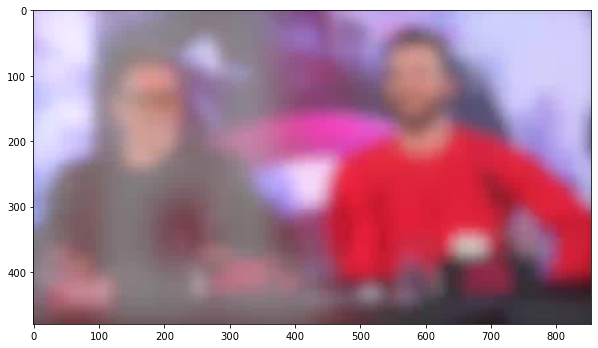

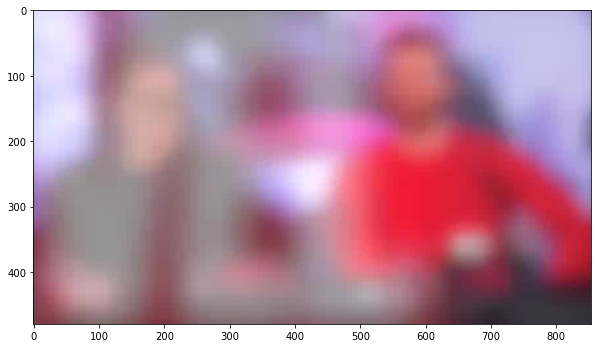

In [22]:
img1_path = clip_3_img_paths[33]
img2_path = clip_3_img_paths[34]
img1 = cv2.imread(str(img1_path))
img2 = cv2.imread(str(img2_path))
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1_rgb)
plt.show()
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2_rgb)
plt.show()

But when camera moves fastly within one scene, the colour histogram will work well because the colour distribution does not change much. Such as the following frame 162 and frame 163 from clip 2. 

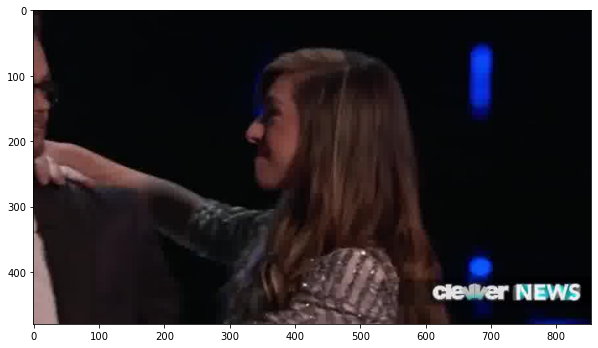

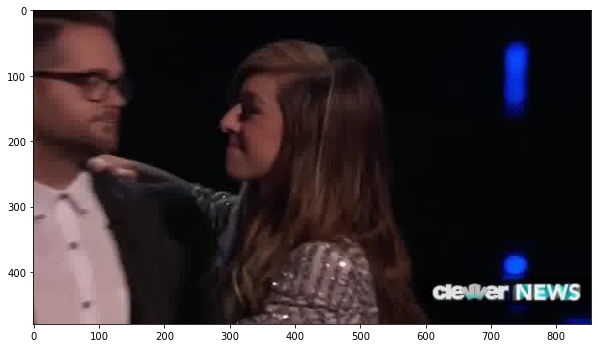

In [23]:
img1_path = clip_2_img_paths[97]
img2_path = clip_2_img_paths[98]
img1 = cv2.imread(str(img1_path))
img2 = cv2.imread(str(img2_path))
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1_rgb)
plt.show()
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2_rgb)
plt.show()

### Edge change ratio

It works better than Colour histogram when there is a lot movement between two frames but colour distribution is similar, such as the frame 54 and 55 from clip 3.

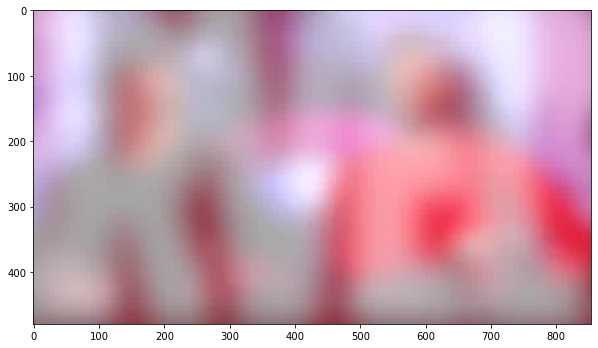

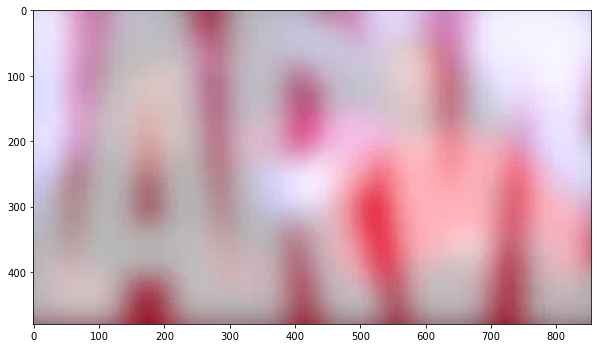

In [24]:
img1_path = clip_3_img_paths[35]
img2_path = clip_3_img_paths[36]
img1 = cv2.imread(str(img1_path))
img2 = cv2.imread(str(img2_path))
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1_rgb)
plt.show()
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2_rgb)
plt.show()

It works poorly when there are large new objects suddenly appeared, such as the frame 34 and 35 from clip 1. Clearly those two frames are within one shot but the edge change ratio between those two frames is high.

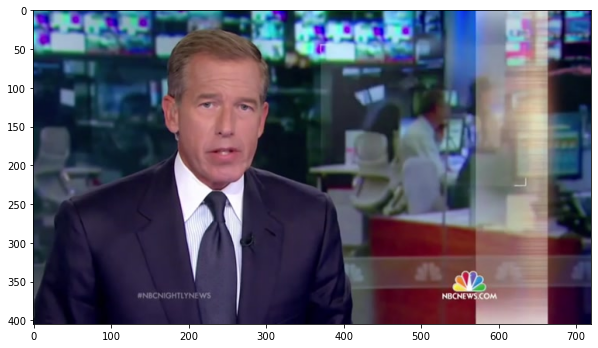

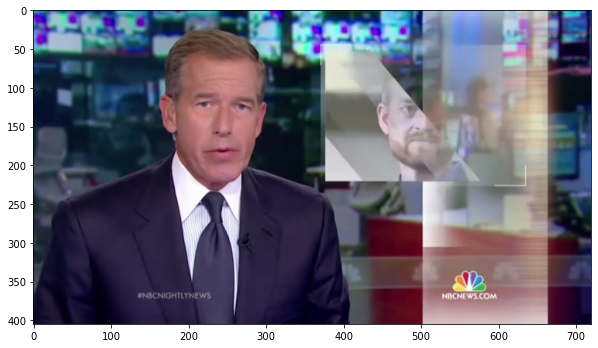

In [25]:
img1_path = clip_1_img_paths[12]
img2_path = clip_1_img_paths[13]
img1 = cv2.imread(str(img1_path))
img2 = cv2.imread(str(img2_path))
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img1_rgb)
plt.show()
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2_rgb)
plt.show()

For test cases we are given, since clip 1 and clip 2 both includes many sudden appears within a shot, color histogram works better in clip 1 and clip 2. For clip 3, most transition scenes is a moving Marvel logo, the logo's colour distribution is similar and color histogram does not work well, but Edge change ratio changes is high when the logo is moving, so Edge change ratio works better for clip 3. 